In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/y_train.npy
/kaggle/input/dataset/y_test.npy
/kaggle/input/dataset/x_test.npy
/kaggle/input/dataset/x_train.npy


In [2]:
x_train = np.load('/kaggle/input/dataset/x_train.npy')
x_test = np.load('/kaggle/input/dataset/x_test.npy')
y_train = np.load('/kaggle/input/dataset/y_train.npy')
y_test = np.load('/kaggle/input/dataset/y_test.npy')

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
import glob

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(53241, 240)
(53241, 140)
(17747, 240)
(17747, 140)


In [5]:
x_train = np.reshape(x_train, (-1,240,1))
x_test = np.reshape(x_test, (-1,240,1))
y_train = np.reshape(y_train, (-1,140,1))
y_test = np.reshape(y_test, (-1,140,1))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(53241, 240, 1)
(53241, 140, 1)
(17747, 240, 1)
(17747, 140, 1)


In [6]:
# x_train = np.array(x_train)
# y_train = np.array(y_train)

train = np.concatenate((x_train, y_train), axis=1)
print(train.shape)
assert(np.array_equal(x_train[0],train[0,:x_train.shape[1]])) ## sanity check if concatenated as expected
train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(6000).batch(128)

(53241, 380, 1)


2022-12-19 20:48:53.252478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:48:53.343155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:48:53.344026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:48:53.347736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
def encoder(input_shape):
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Conv1D(32, 3, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv1D(64, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv1D(64, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv1D(64, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  flatten = tf.keras.layers.Flatten()(x)
  bottleneck = tf.keras.layers.Dense(200)(flatten)

  model = tf.keras.Model(inputs, bottleneck, name='Encoder')

  return model

In [29]:
encoder((240,1)).summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 1)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 240, 32)           128       
_________________________________________________________________
batch_normalization_11 (Batc (None, 240, 32)           128       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 240, 64)           6208      
_________________________________________________________________
batch_normalization_12 (Batc (None, 240, 64)           256       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 240, 64)           12352     
_________________________________________________________________
batch_normalization_13 (Batc (None, 240, 64)           256 

In [30]:
def decoder(input_shape):
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Dense(64)(inputs)
  x = tf.reshape(x, [-1, 8, 8])

  x = tf.keras.layers.Conv1DTranspose(64, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv1DTranspose(64, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv1DTranspose(32, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
#   x = tf.keras.layers.LeakyReLU()(x)
    
  flatten = tf.keras.layers.Flatten()(x)
  outputs = tf.keras.layers.Dense(140)(flatten)

  model = tf.keras.Model(inputs, outputs, name='Decoder')

  return model

In [31]:
print(x_train[0].shape)
print(x_train.shape[1:])
enc = encoder((x_train.shape[1:]))
dec = decoder((200, ))

(240, 1)
(240, 1)


In [32]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                12864     
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 8, 8)              0         
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 8, 64)             1600      
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 64)             256       
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 8, 64)             12352     
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 64)             256 

In [33]:
## have to create a loss function for tensors

from tensorflow.keras import backend as K
def loss(y_true, y_pred):
  return K.mean(K.square(y_true-y_pred), axis=[1,2,3])

In [34]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
loss = tf.keras.losses.MeanSquaredError()

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
from tensorflow.python import training
@tf.function
def train_step(batch):
    gene_batch = batch[:, :240,:]
    protien_exp_batch = batch[:, 240:,:]
    protien_exp_batch = tf.reshape(protien_exp_batch, [-1,140])
    print(protien_exp_batch.shape)
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        latent = enc(gene_batch, training=True)
        decoded_protien_exp = dec(latent, training=True)
        mse_loss = loss(decoded_protien_exp, protien_exp_batch)
    grad_encoder = encoder.gradient(mse_loss, enc.trainable_variables)
    grad_decoder = decoder.gradient(mse_loss, dec.trainable_variables)

    optimizer.apply_gradients(zip(grad_encoder, enc.trainable_variables))
    optimizer.apply_gradients(zip(grad_decoder, dec.trainable_variables))

    return mse_loss

In [36]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i=0
        for batch in dataset:
            i+=1
            if(i/100==0):
                print(i)
            loss = train_step(batch)
            plt_batch = [3,3]
            total_gene_in_batch = plt_batch[0] * plt_batch[1]
        print(loss)
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

In [49]:
train(train_dataset, 20) ## dont forget to save model on checkpoint

tf.Tensor(2.616821, shape=(), dtype=float32)
Time for epoch 1 is 3.5340709686279297 sec
tf.Tensor(3.0528352, shape=(), dtype=float32)
Time for epoch 2 is 3.547001361846924 sec
tf.Tensor(2.736678, shape=(), dtype=float32)
Time for epoch 3 is 3.581204891204834 sec
tf.Tensor(3.0721052, shape=(), dtype=float32)
Time for epoch 4 is 3.526456117630005 sec
tf.Tensor(2.6743867, shape=(), dtype=float32)
Time for epoch 5 is 3.5993990898132324 sec
tf.Tensor(2.6170137, shape=(), dtype=float32)
Time for epoch 6 is 3.7300214767456055 sec
tf.Tensor(2.5399306, shape=(), dtype=float32)
Time for epoch 7 is 3.539698362350464 sec
tf.Tensor(2.637088, shape=(), dtype=float32)
Time for epoch 8 is 3.5302035808563232 sec
tf.Tensor(2.7874637, shape=(), dtype=float32)
Time for epoch 9 is 3.612762689590454 sec
tf.Tensor(2.5913482, shape=(), dtype=float32)
Time for epoch 10 is 3.532938241958618 sec
tf.Tensor(2.5089018, shape=(), dtype=float32)
Time for epoch 11 is 3.5345089435577393 sec
tf.Tensor(2.5936542, shape=(

In [50]:
x_test.shape

(17747, 240, 1)

In [51]:
print(y_test.shape)
y_test = np.reshape(y_test, (17747, 140))
print(y_test.shape)            

(17747, 140)
(17747, 140)


In [52]:
latent = enc(x_test, training=False)
y_pred = dec(latent, training=False)

In [53]:
y_pred = y_pred.numpy()
y_pred.shape

(17747, 140)

In [54]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.20635976280346316

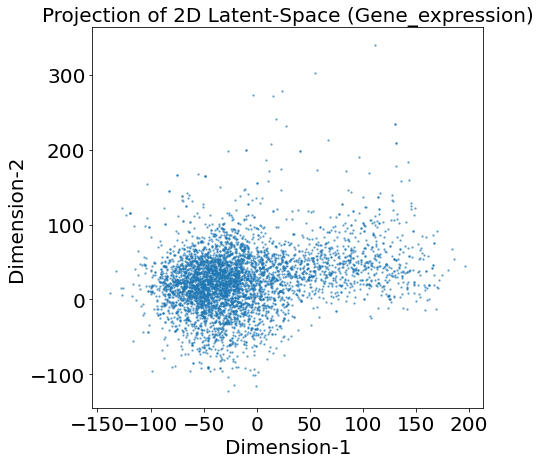

In [56]:
n_to_show = 5000
figsize = 7

index = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[index]

embeddings = enc.predict(example_images)


plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Gene_expression)", size=20)
plt.show()

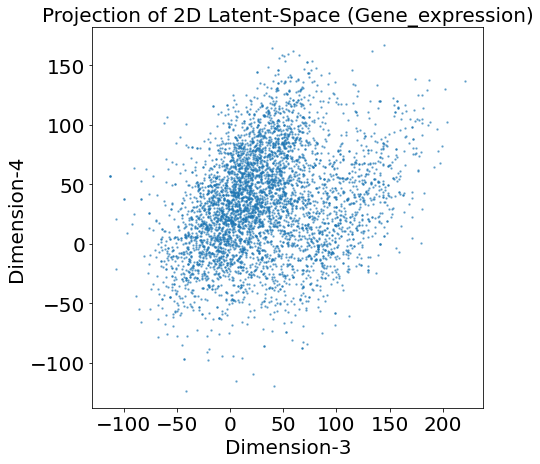

In [59]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 2] , embeddings[:, 3], alpha=0.5, s=2)
plt.xlabel("Dimension-3", size=20)
plt.ylabel("Dimension-4", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Gene_expression)", size=20)
plt.show()